<a href="https://colab.research.google.com/github/yudumpacin/Earthquakes-in-Turkey/blob/main/Kandilli_Earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Earthquakes in Turkey**

Kandilli Rasathanesi webpage gives information about last 500 earthquakes in Turkey and near Turkey, these information is updated regularly. I will analyze this data using Pyhton libraries.

In [ ]:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [ ]:
#Necessary Libraries are imported
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import requests as req
import matplotlib.pyplot as plt
import seaborn as sn
import folium
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
from sklearn.preprocessing import StandardScaler

# 1- Data

Earthquake data is extracted from Kandilli Rasathanesi wep page.
Data consists of last 500 earthquake happened in Turkey. Each data sample has these features; date, latitude,longtitude, depth, magnitute, name of place, and attribute of solution (primary,revised)

### Extract the  Data from webpage

In [248]:
# I will extract data with Beautifoulsoup and request library
link = 'http://www.koeri.boun.edu.tr/scripts/lst5.asp'
re = req.get(link)
soup = bs(re.content)

In [249]:
data_all = soup.find('pre').get_text().split('\r\n')

In [250]:
feature = data_all[5:6]

In [251]:
data = data_all[7:]

In [252]:
data[:5]

['2021.06.20 18:39:51  40.6725   30.5147        7.4      -.-  2.3  -.-   TEKETABAN-KARAPURCEK (SAKARYA)                    İlksel',
 '2021.06.20 17:15:43  40.0698   28.7790        6.5      -.-  2.9  -.-   CINARCIK-ORHANELI (BURSA)                         İlksel',
 '2021.06.20 17:15:12  40.0600   28.8048        8.8      -.-  2.7  -.-   CINARCIK-ORHANELI (BURSA)                         İlksel',
 '2021.06.20 16:56:35  37.2880   37.9928       20.3      -.-  3.5  3.7   ERIKLI-HALFETI (SANLIURFA)                        İlksel',
 '2021.06.20 15:06:26  35.1683   23.5130       16.9      -.-  2.6  -.-   GIRIT ADASI (AKDENIZ)                             İlksel']

In [253]:
feature

['Tarih      Saat      Enlem(N)  Boylam(E) Derinlik(km)  MD   ML   Mw    Yer                                             Çözüm Niteliği']

In [254]:
#drop "çözüm niteliği" feature, since  çözüm niteliği (characterictic of resolution), it is whether primary, i.e. the info is given without revized, or revized
feature = ['Tarih' ,'Saat' , 'Enlem(N)'  ,'Boylam(E)','Derinlik(km)','MD','ML','Mw','Yer']

In [255]:
df = pd.DataFrame(data)

In [256]:
df = df[0].str.split(' ', expand=True)

In [257]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,2021.06.20,18:39:51,,40.6725,,,30.5147,,,,,,,,7.4,,,,,,-.-,,2.3,,-.-,,,TEKETABAN-KARAPURCEK,(SAKARYA),,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,2021.06.20,17:15:43,,40.0698,,,28.7790,,,,,,,,6.5,,,,,,-.-,,2.9,,-.-,,,CINARCIK-ORHANELI,(BURSA),,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,2021.06.20,17:15:12,,40.0600,,,28.8048,,,,,,,,8.8,,,,,,-.-,,2.7,,-.-,,,CINARCIK-ORHANELI,(BURSA),,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,2021.06.20,16:56:35,,37.2880,,,37.9928,,,,,,,20.3,,,,,,-.-,,3.5,,3.7,,,ERIKLI-HALFETI,(SANLIURFA),,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,2021.06.20,15:06:26,,35.1683,,,23.5130,,,,,,,16.9,,,,,,-.-,,2.6,,-.-,,,GIRIT,ADASI,(AKDENIZ),,,,,,,,,,,,,,,,,,,,,,,,,,,,,İlksel,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [258]:
df = df.iloc[:,:29]

In [259]:
df.drop([2,4,5,7,	8	,9,	10,	11	,12,15,	16	,17,	18],axis=1,inplace=True)
df[13] = df[13]+df[14]
df[19] = df[19]+df[20]
df[21] = df[21]+df[22]
df[23] = df[23]+df[24]
df[26] = df[26]+' '+df[27]+' '+df[28]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28
0,2021.06.20,18:39:51,,40.6725,,,30.5147,,,,,,,,7.4,,,,,,-.-,,2.3,,-.-,,,TEKETABAN-KARAPURCEK,(SAKARYA)
1,2021.06.20,17:15:43,,40.0698,,,28.7790,,,,,,,,6.5,,,,,,-.-,,2.9,,-.-,,,CINARCIK-ORHANELI,(BURSA)
2,2021.06.20,17:15:12,,40.0600,,,28.8048,,,,,,,,8.8,,,,,,-.-,,2.7,,-.-,,,CINARCIK-ORHANELI,(BURSA)
3,2021.06.20,16:56:35,,37.2880,,,37.9928,,,,,,,20.3,,,,,,-.-,,3.5,,3.7,,,ERIKLI-HALFETI,(SANLIURFA),
4,2021.06.20,15:06:26,,35.1683,,,23.5130,,,,,,,16.9,,,,,,-.-,,2.6,,-.-,,,GIRIT,ADASI,(AKDENIZ)


In [ ]:
df.drop([14],axis=1,inplace=True)
df.drop([20],axis=1,inplace=True)
df.drop([22],axis=1,inplace=True)
df.drop([24],axis=1,inplace=True)
df.drop([25],axis=1,inplace=True)
df.drop([27],axis=1,inplace=True)
df.drop([28],axis=1,inplace=True)

In [264]:
df.columns=feature

In [267]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),MD,ML,Mw,Yer
0,2021.06.20,18:39:51,40.6725,30.5147,7.4,-.-,2.3,-.-,TEKETABAN-KARAPURCEK (SAKARYA)
1,2021.06.20,17:15:43,40.0698,28.7790,6.5,-.-,2.9,-.-,CINARCIK-ORHANELI (BURSA)
2,2021.06.20,17:15:12,40.0600,28.8048,8.8,-.-,2.7,-.-,CINARCIK-ORHANELI (BURSA)
3,2021.06.20,16:56:35,37.2880,37.9928,20.3,-.-,3.5,3.7,ERIKLI-HALFETI (SANLIURFA)
4,2021.06.20,15:06:26,35.1683,23.5130,16.9,-.-,2.6,-.-,GIRIT ADASI (AKDENIZ)


# 2. Preprocessing

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tarih         502 non-null    object
 1   Saat          500 non-null    object
 2   Enlem(N)      500 non-null    object
 3   Boylam(E)     500 non-null    object
 4   Derinlik(km)  500 non-null    object
 5   MD            500 non-null    object
 6   ML            500 non-null    object
 7   Mw            500 non-null    object
 8   Yer           500 non-null    object
dtypes: object(9)
memory usage: 35.4+ KB


In [269]:
df.replace('-.-',np.NAN,inplace=True)

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Tarih         502 non-null    object
 1   Saat          500 non-null    object
 2   Enlem(N)      500 non-null    object
 3   Boylam(E)     500 non-null    object
 4   Derinlik(km)  500 non-null    object
 5   MD            2 non-null      object
 6   ML            499 non-null    object
 7   Mw            20 non-null     object
 8   Yer           500 non-null    object
dtypes: object(9)
memory usage: 35.4+ KB


In [271]:
#MD and Mw values are mostly null, so drop these two columns from dataframe
df.drop(['MD','Mw'],axis=1,inplace=True)

In [272]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),ML,Yer
0,2021.06.20,18:39:51,40.6725,30.5147,7.4,2.3,TEKETABAN-KARAPURCEK (SAKARYA)
1,2021.06.20,17:15:43,40.0698,28.7790,6.5,2.9,CINARCIK-ORHANELI (BURSA)
2,2021.06.20,17:15:12,40.0600,28.8048,8.8,2.7,CINARCIK-ORHANELI (BURSA)
3,2021.06.20,16:56:35,37.2880,37.9928,20.3,3.5,ERIKLI-HALFETI (SANLIURFA)
4,2021.06.20,15:06:26,35.1683,23.5130,16.9,2.6,GIRIT ADASI (AKDENIZ)


In [273]:
#convert numerical features
df['Enlem(N)'] = pd.to_numeric(df['Enlem(N)'])
df['Boylam(E)'] = pd.to_numeric(df['Boylam(E)'])
df['Derinlik(km)'] = pd.to_numeric(df['Derinlik(km)'])
df['ML'] = pd.to_numeric(df['ML'])

In [274]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tarih         502 non-null    object 
 1   Saat          500 non-null    object 
 2   Enlem(N)      500 non-null    float64
 3   Boylam(E)     500 non-null    float64
 4   Derinlik(km)  498 non-null    float64
 5   ML            499 non-null    float64
 6   Yer           500 non-null    object 
dtypes: float64(4), object(3)
memory usage: 27.6+ KB


In [275]:
#convert date feature
df['TarihSaat'] = df['Tarih'] +' '+ df['Saat']
df['TarihSaat'] = pd.to_datetime(df['TarihSaat'])

In [276]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),ML,Yer,TarihSaat
0,2021.06.20,18:39:51,40.6725,30.5147,7.4,2.3,TEKETABAN-KARAPURCEK (SAKARYA),2021-06-20 18:39:51
1,2021.06.20,17:15:43,40.0698,28.7790,6.5,2.9,CINARCIK-ORHANELI (BURSA),2021-06-20 17:15:43
2,2021.06.20,17:15:12,40.0600,28.8048,8.8,2.7,CINARCIK-ORHANELI (BURSA),2021-06-20 17:15:12
3,2021.06.20,16:56:35,37.2880,37.9928,20.3,3.5,ERIKLI-HALFETI (SANLIURFA),2021-06-20 16:56:35
4,2021.06.20,15:06:26,35.1683,23.5130,16.9,2.6,GIRIT ADASI (AKDENIZ),2021-06-20 15:06:26


In [389]:
df.isna().sum()

Tarih           0
Saat            2
Enlem(N)        2
Boylam(E)       2
Derinlik(km)    4
ML              3
Yer             2
TarihSaat       2
dtype: int64

In [390]:
df = df.dropna()

# 2. EDA (Exploratory Data Analysis)


In [277]:
df.head()

,Tarih,Saat,Enlem(N),Boylam(E),Derinlik(km),ML,Yer,TarihSaat
0,2021.06.20,18:39:51,40.6725,30.5147,7.4,2.3,TEKETABAN-KARAPURCEK (SAKARYA),2021-06-20 18:39:51
1,2021.06.20,17:15:43,40.0698,28.7790,6.5,2.9,CINARCIK-ORHANELI (BURSA),2021-06-20 17:15:43
2,2021.06.20,17:15:12,40.0600,28.8048,8.8,2.7,CINARCIK-ORHANELI (BURSA),2021-06-20 17:15:12
3,2021.06.20,16:56:35,37.2880,37.9928,20.3,3.5,ERIKLI-HALFETI (SANLIURFA),2021-06-20 16:56:35
4,2021.06.20,15:06:26,35.1683,23.5130,16.9,2.6,GIRIT ADASI (AKDENIZ),2021-06-20 15:06:26


In [320]:
from datetime import datetime, timedelta
last_hour_date_time = datetime.now() - timedelta(hours = 1)
print(last_hour_date_time.strftime('%Y-%m-%d %H:%M:%S'))

2021-06-20 15:35:34


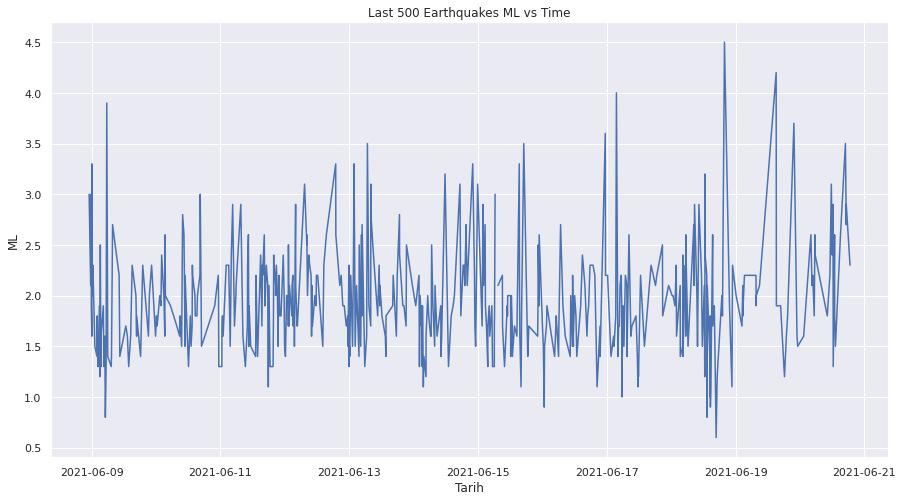

In [382]:
plt.figure(figsize=(15,8))
plt.plot(df['TarihSaat'], df['ML'])
plt.xlabel('Tarih')
plt.ylabel('ML')
plt.title('Last 500 Earthquakes ML vs Time')
plt.show()


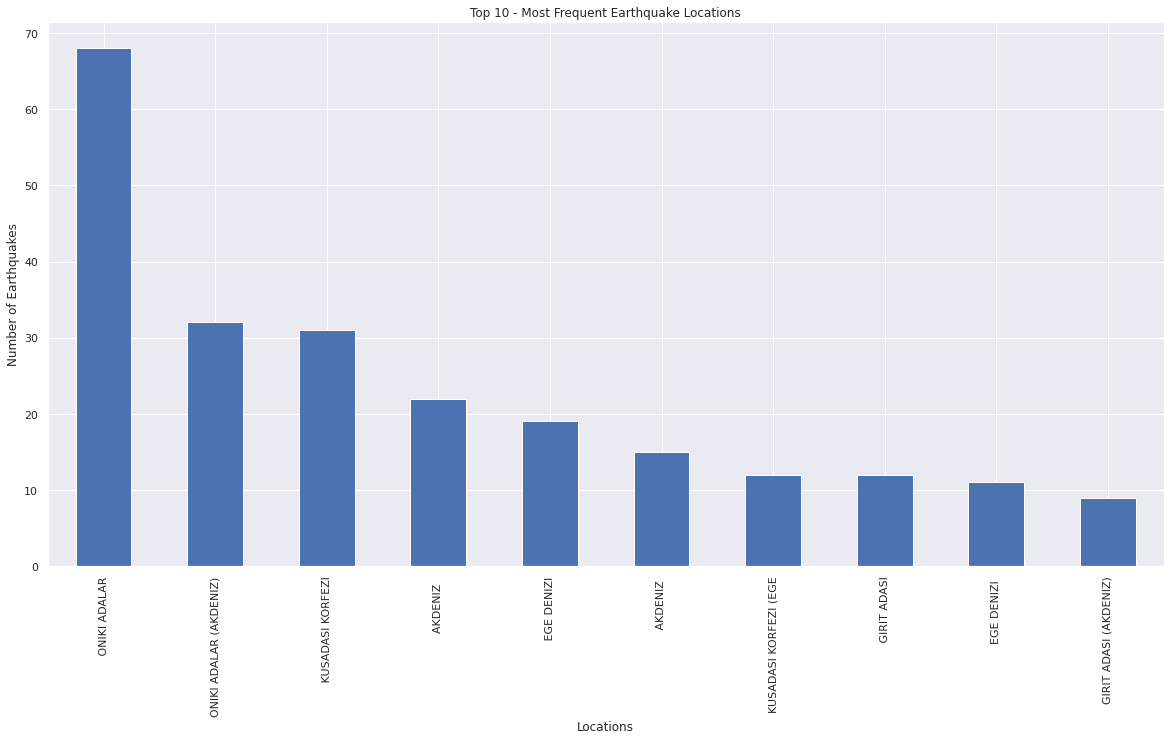

In [417]:
df['Yer'].value_counts().sort_values(ascending=False)[0:10].plot(kind='bar')
plt.title('Top 10 - Most Frequent Earthquake Locations')
plt.ylabel('Number of Earthquakes')
plt.xlabel('Locations')
plt.show()

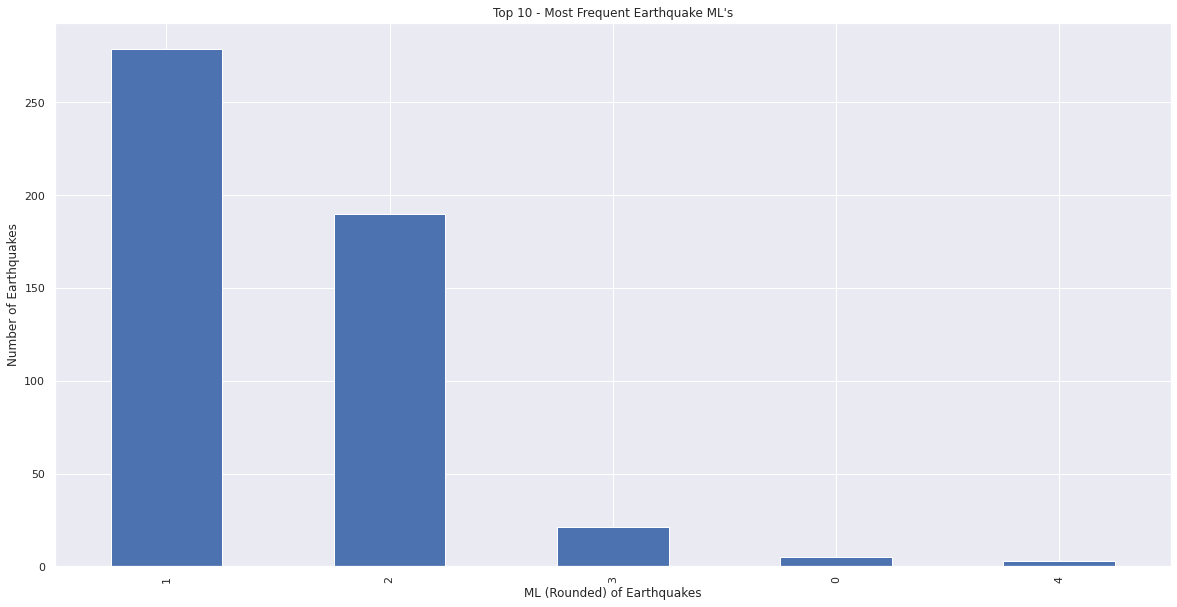

In [419]:
df['ML'].astype(int).value_counts().sort_values(ascending=False)[0:10].plot(kind='bar')
plt.title('Top 10 - Most Frequent Earthquake ML\'s')
plt.ylabel('Number of Earthquakes')
plt.xlabel('ML (Rounded) of Earthquakes')
plt.show()

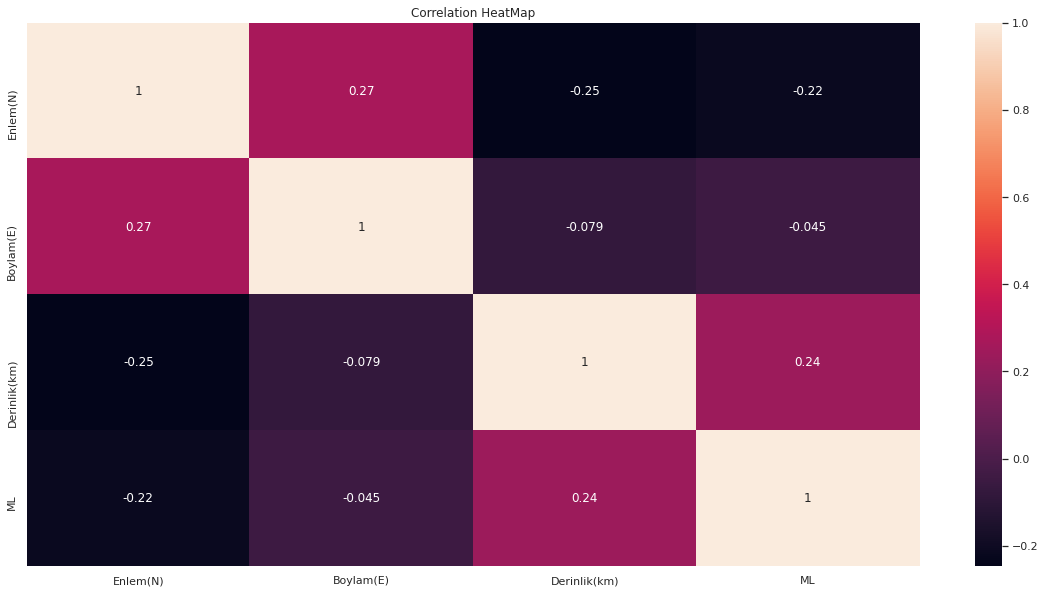

In [385]:
corr = df.drop(['Yer','Tarih','Saat'],axis=1).corr()
sn.heatmap(corr,annot=True)
plt.title('Correlation HeatMap')
plt.show()

Correlation heatmap shows, there is not a strong realtionship between features (max. correlation is 0.27), or other features to ML. ML and Derinlik (depth) have a little positive correlation (0.24). Also, latitude, longtitue have positive correlation, which results from the location of the data which is Turkey and the locations near Turkey.
 This results need future analysis

In [387]:
latitude = df['Enlem(N)'].mean()
longitude = df['Boylam(E)'].mean()

Visualize the data with map

In [442]:
# create map
map_clusters = folium.Map(location=[latitude,longitude],zoom_start=7)

# add markers to the map
markers_colors = []
for lat, lon, yer, derinlik, ml in zip(df['Enlem(N)'], df['Boylam(E)'],df['Yer'] ,df['Derinlik(km)'],df['ML']):
    label = folium.Popup( parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5*ml,
        popup="Yer:"+ str(yer)+"\nŞiddet:"+str(ml) +"\nDerinlik:"+str(derinlik),
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 3. ML Application

First, I will try to predict ML of the data with linear and ensemble models

* Linear Regression Model

In [454]:
y = df['ML']
X = df.drop(['Tarih','Saat','Yer','TarihSaat','ML'],axis=1)

In [457]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [458]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

In [467]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
print('Linear Regression Model mean squares error is: ',mean_squared_error(y_test,y_pred))

Linear Regression Model mean squares error is:  0.2378336138200775


In [460]:
weighs = lr.coef_
features=X.columns

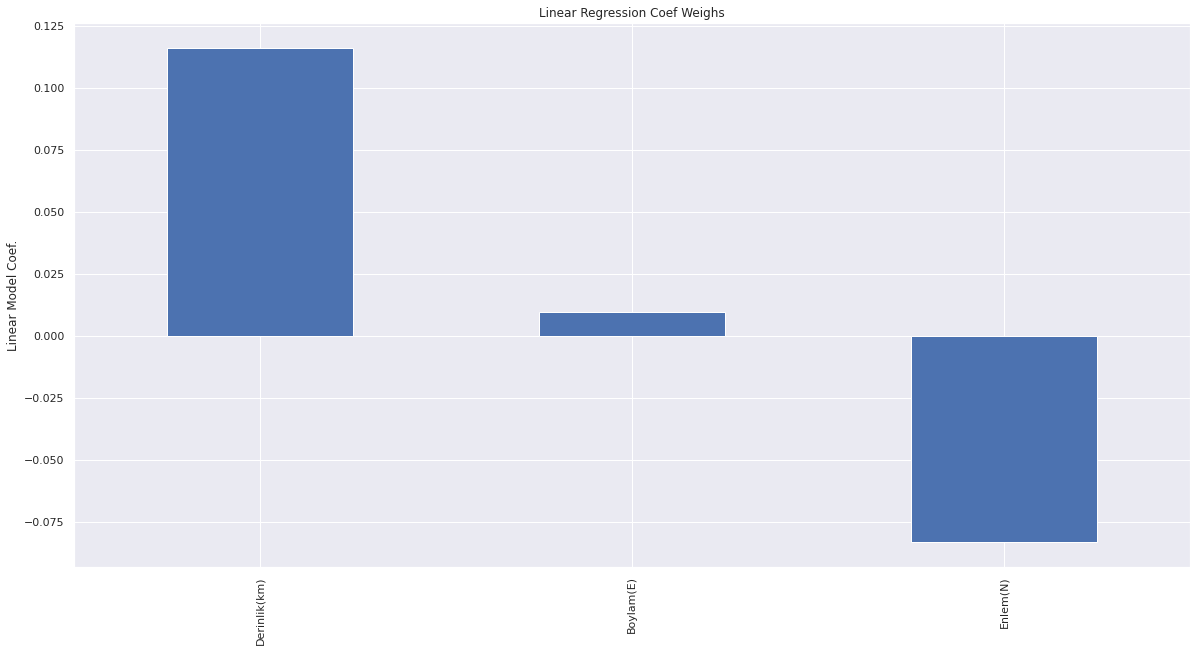

In [466]:
pd.Series(weighs, index=features).sort_values(ascending=False).plot(kind='bar')
plt.title('Linear Regression Coef Weighs')
plt.ylabel('Linear Model Coef.')
plt.show()

Derinlik(km)-Depth effects ML positively. Deeper earthquakes, make bigger ML.

Enlem(N)-Latitude effects ML negatively, smaller ML earthques happen when we go north locations in near Turkey

* Random Forest Regression Model

In [462]:
y = df['ML']
X = df.drop(['Tarih','Saat','Yer','TarihSaat','ML'],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.3,random_state=42)

In [468]:
rfr = RandomForestRegressor()
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print('Random Forest Regression Model mean squares error is: ',mean_squared_error(y_test,y_pred))

Random Forest Regression Model mean squares error is:  0.24287412666666655


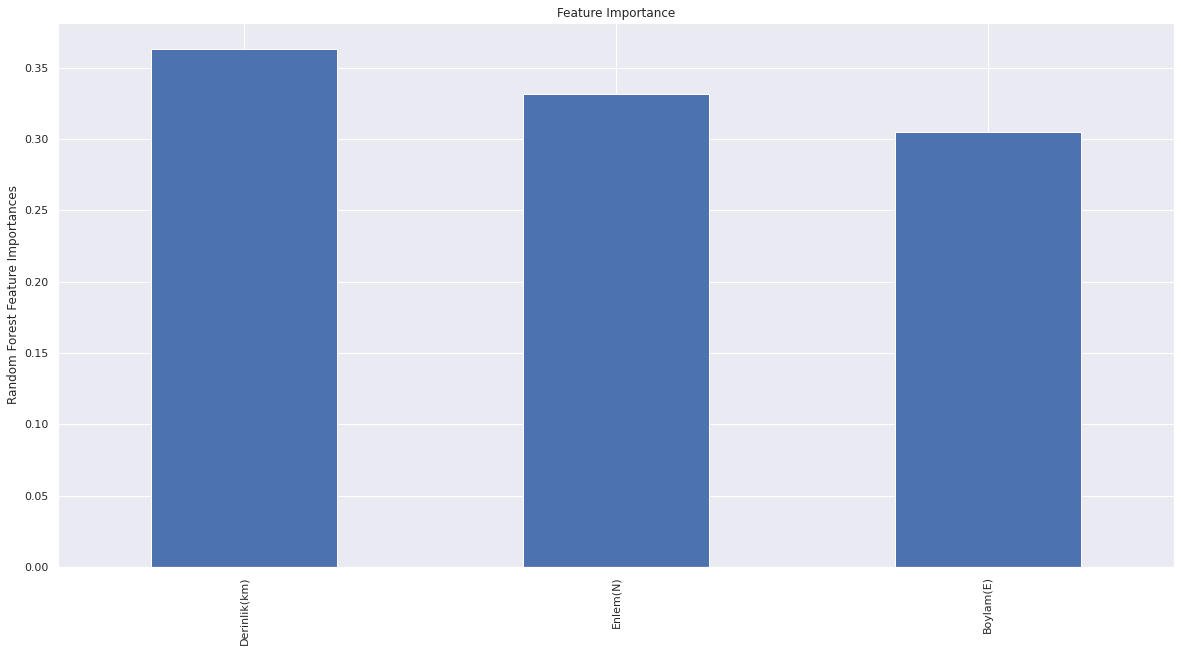

In [465]:
pd.Series(rfr.feature_importances_, index=features).sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Random Forest Feature Importances')
plt.show()

Similar to linear model, derinlik(km)-depth is the strongest feature effecting ML, and Enlem(N) is the second feature effecting ML